## Кольцевая решетка

Регулярный граф – ​это граф, в котором каждый узел имеет одинаковое количество соседей;  
Количество соседей также называется степенью узла.

Кольцевая решетка является своего рода регулярным графом, который Ваттс и Строгац используют
в качестве основы своей модели. В кольцевой решетке с n узлами узлы могут быть расположены
по кругу, причем каждый узел соединен с k ближайшими соседями.


**Регулярный это тот граф, у которого степени всех вершин равны**

In [1]:
import networkx as nx

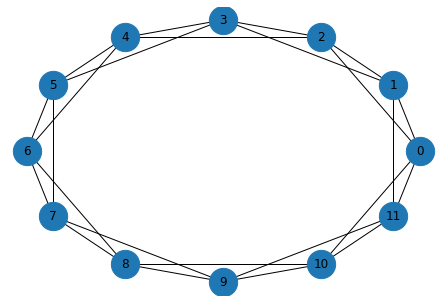

In [2]:
def adjacent_edges(nodes, k):
    n = len(nodes)
    for i, node1 in enumerate(nodes):
        for j in range(i+1, i + k//2 + 1):
            node2 = nodes[j % n]
            yield node1, node2
            
            
def make_circular_graph(size, k):
    nodes = range(size)
    g = nx.Graph()
    
    g.add_nodes_from(nodes)
    g.add_edges_from(adjacent_edges(nodes, k))
    
    return g

g = make_circular_graph(12, 5)
nx.draw_circular(g, with_labels=True, node_size=800)

## Графы Ваттса–Строгаца

Чтобы построить граф Ваттса–Строгаца, мы начнем с кольцевой решетки и «переплетем» некоторые
ребра. В своей работе Ваттс и Строгац рассматривают ребра в определенном порядке и перепле-
тают каждое с вероятностью p. Если ребро переплетено, они оставляют первый узел без измене-
ний и выбирают второй узел случайным образом. Они не допускают петель или нескольких ребер;
то есть у вас не может быть ребра от узла к самому себе, и нельзя иметь более одного ребра между
двумя одинаковыми узлами.

In [3]:
import numpy as np

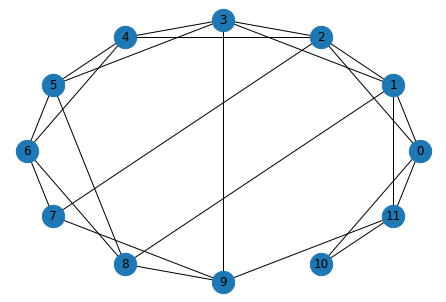

In [4]:
def flip(p):
    return np.random.random() < p

def rewire(g, p):
    nodes = set(g)
    for node1, node2 in g.edges():
        if flip(p):
            choices = nodes - {node1} - set(g.neighbors(node1))
            new_node2 = np.random.choice(list(choices))
            
            g.remove_edge(node1, node2)
            g.add_edge(node1, new_node2)
            
            
    return g


graph = make_circular_graph(12, 4)

rewire(graph, 0.2)
nx.draw_circular(graph, with_labels=True, node_size=500)

## Кластеризация

Клика – это подмножество узлов, которые полно-
стью связаны; то есть существуют ребра между всеми парами узлов в подмножестве.

Предположим, у определенного узла u есть k соседей. Если все соседи связаны друг с другом, между
ними будет (k – ​1)k/2 ребер. Доля ребер, которые действительно существуют, является локальным
коэффициентом кластеризации u, обозначаемым $C_{u}$ .
Если мы вычислим среднее значение C u по всем узлам, то получим «средний коэффициент класте-
ризации в сети», обозначенный как $C^{-}$.

In [5]:
from itertools import combinations

def cluster_node(g, node):
    neighbors = list(g.neighbors(node))
    
    k = len(neighbors)
    
    if k < 2:
        return np.nan
    
    possible = ((k-1) * k) / 2
    exist_edges = 0
    for node1, node2 in combinations(neighbors, 2):
        if g.has_edge(node1, node2):
            exist_edges += 1
            
    return round(exist_edges / possible, 2)


def clustering_coefficient(g):
    return np.nanmean([cluster_node(g, node) for node in g])

g = make_circular_graph(10, 4)
rewire(g, 0.9)

clustering_coefficient(g)

0.5333333333333333

## Длина кратчайшего пути
Следующим шагом является вычисление длины пути L, которая является средней длиной кратчай-
шего пути между каждой парой узлов.

In [6]:
from itertools import combinations

def get_mean_length(g):
    length_map = dict(nx.shortest_path_length(g))

    return np.nanmean([length_map[node1].get(node2, np.nan) for node1, node2 in combinations(g.nodes, 2)])

In [7]:
g = make_circular_graph(3, 2)
get_mean_length(g)

1.0

## Эксперимент Ваттса–Строгаца

Теперь можно повторить эксперимент Ваттса–Строгаца, который показывает, что для диапазона
значений p граф Ваттса–Строгаца имеет высокую кластеризацию, как у регулярного графа, и корот-
кую длину пути, как у случайного графа.

Я начну с run_one_graph, который принимает n, k и p; он генерирует граф Ваттса–Строгаца с задан-
ными параметрами и вычисляет среднюю длину пути, mpl, и коэффициент кластеризации, cc

In [8]:
def run_one_graph(size, k, p):
    g = make_circular_graph(size, k)
    rewire(g, p)
    
    mpl = get_mean_length(g)
    cc = clustering_coefficient(g)
    
    return mpl, cc


def run_experiment(ps, size=1000, k=10, iters=20):
    res = []
    
    for p in ps:
        means = np.array([run_one_graph(size, k, p) for _ in range(iters)]).mean(axis=0)
        res.append(means)
    
    return np.array(res)   

result = run_experiment(np.arange(0, 1, 0.08))

In [9]:
L, C = np.transpose(result)

L /= L[0]
C /= C[0]

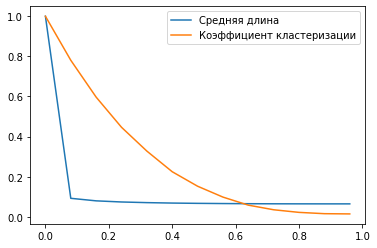

In [11]:
import matplotlib.pyplot as plt


plt.plot(np.arange(0, 1, 0.08), L)
plt.plot(np.arange(0, 1, 0.08), C)

plt.legend(['Средняя длина', 'Коэффициент кластеризации'])
plt.show()